In [4]:
import pandas as pd
import numpy as np
from collections import defaultdict
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
class VideoRecommenderEvaluator:
    """
    Evaluation framework for video recommendation system with visual analytics.
    """
    
    def __init__(self, nn_model, tfidf_vectorizer, dataset, k=5):
        """
        Parameters:
        -----------
        nn_model : NearestNeighbors model
        tfidf_vectorizer : TfidfVectorizer
        dataset : DataFrame with video data
        k : int, number of recommendations to evaluate
        """
        self.nn_model = nn_model
        self.vectorizer = tfidf_vectorizer
        self.dataset = dataset
        self.k = k
        self.tfidf_matrix = None
        
    def prepare_ground_truth(self, interaction_data):
        """
        Create ground truth from interaction data.
        Positive interactions: 'liked', 'commented', 'shared', 'watched'
        
        Parameters:
        -----------
        interaction_data : DataFrame
            Original dataset with student_id, video_title, interaction_type
        
        Returns:
        --------
        dict : {student_id: {video_title: set of positive interaction videos}}
        """
        positive_interactions = ['liked', 'commented', 'shared', 'watched']
        
        positive_data = interaction_data[
            interaction_data['interaction_type'].isin(positive_interactions)
        ]
        
        ground_truth = {}
        
        for student_id in positive_data['student_id'].unique():
            student_videos = positive_data[
                positive_data['student_id'] == student_id
            ]['video_title'].tolist()
            
            ground_truth[student_id] = {}
            
            for video in student_videos:
                relevant = [v for v in student_videos if v != video]
                if relevant:
                    ground_truth[student_id][video] = set(relevant)
        
        return ground_truth
    
    def get_recommendations(self, video_title, num_recommendations=5):
        """Get recommendations using the model"""
        try:
            idx = self.dataset[self.dataset['video_title'] == video_title].index[0]
        except IndexError:
            return []
        
        if self.tfidf_matrix is None:
            self.tfidf_matrix = self.vectorizer.transform(self.dataset['content'])
        
        distances, indices = self.nn_model.kneighbors(
            self.tfidf_matrix[idx], 
            n_neighbors=num_recommendations + 1
        )
        
        similar_indices = indices.flatten()[1:]
        recommended_titles = self.dataset.iloc[similar_indices]['video_title'].tolist()
        
        return recommended_titles[:num_recommendations]
    
    def precision_at_k(self, recommended, relevant):
        """Calculate Precision@K"""
        if len(recommended) == 0:
            return 0.0
        
        recommended_set = set(recommended[:self.k])
        relevant_set = set(relevant)
        
        hits = len(recommended_set & relevant_set)
        return hits / min(len(recommended_set), self.k)
    
    def recall_at_k(self, recommended, relevant):
        """Calculate Recall@K"""
        if len(relevant) == 0:
            return 0.0
        
        recommended_set = set(recommended[:self.k])
        relevant_set = set(relevant)
        
        hits = len(recommended_set & relevant_set)
        return hits / len(relevant_set)
    
    def hit_rate_at_k(self, recommended, relevant):
        """Calculate Hit Rate@K"""
        recommended_set = set(recommended[:self.k])
        relevant_set = set(relevant)
        
        return 1 if len(recommended_set & relevant_set) > 0 else 0
    
    def ndcg_at_k(self, recommended, relevant):
        """Calculate NDCG@K"""
        def dcg(scores):
            scores = np.array(scores)[:self.k]
            if scores.size == 0:
                return 0.0
            return np.sum(scores / np.log2(np.arange(2, scores.size + 2)))
        
        relevant_set = set(relevant)
        
        rec_scores = [1 if item in relevant_set else 0 
                     for item in recommended[:self.k]]
        dcg_score = dcg(rec_scores)
        
        ideal_scores = [1] * min(len(relevant_set), self.k)
        idcg = dcg(ideal_scores)
        
        if idcg == 0:
            return 0.0
        
        return dcg_score / idcg
    
    def evaluate(self, ground_truth, sample_size=None, store_details=False):
        """
        Evaluate the recommender system
        
        Parameters:
        -----------
        ground_truth : dict
            Output from prepare_ground_truth()
        sample_size : int, optional
            Number of user-video pairs to evaluate
        store_details : bool
            If True, stores detailed metrics per evaluation
        
        Returns:
        --------
        dict : Evaluation metrics and optionally detailed results
        """
        metrics = defaultdict(list)
        details = [] if store_details else None
        evaluated_pairs = 0
        
        for student_id, video_dict in ground_truth.items():
            for video_title, relevant_videos in video_dict.items():
                if sample_size and evaluated_pairs >= sample_size:
                    break
                
                recommended = self.get_recommendations(video_title, self.k)
                
                if len(recommended) == 0:
                    continue
                
                precision = self.precision_at_k(recommended, relevant_videos)
                recall = self.recall_at_k(recommended, relevant_videos)
                hit_rate = self.hit_rate_at_k(recommended, relevant_videos)
                ndcg = self.ndcg_at_k(recommended, relevant_videos)
                
                metrics['precision'].append(precision)
                metrics['recall'].append(recall)
                metrics['hit_rate'].append(hit_rate)
                metrics['ndcg'].append(ndcg)
                
                if store_details:
                    details.append({
                        'student_id': student_id,
                        'video_title': video_title,
                        'precision': precision,
                        'recall': recall,
                        'hit_rate': hit_rate,
                        'ndcg': ndcg,
                        'num_relevant': len(relevant_videos)
                    })
                
                evaluated_pairs += 1
            
            if sample_size and evaluated_pairs >= sample_size:
                break
        
        results = {
            f'Precision@{self.k}': np.mean(metrics['precision']) if metrics['precision'] else 0.0,
            f'Recall@{self.k}': np.mean(metrics['recall']) if metrics['recall'] else 0.0,
            f'Hit Rate@{self.k}': np.mean(metrics['hit_rate']) if metrics['hit_rate'] else 0.0,
            f'NDCG@{self.k}': np.mean(metrics['ndcg']) if metrics['ndcg'] else 0.0,
            'evaluated_pairs': evaluated_pairs,
            'raw_metrics': metrics,
            'details': details
        }
        
        return results
    
    def evaluate_multiple_k(self, ground_truth, k_values=[1, 3, 5, 10], sample_size=None):
        """
        Evaluate for multiple K values
        
        Returns:
        --------
        DataFrame : Metrics for each K value
        """
        results_list = []
        
        for k in k_values:
            original_k = self.k
            self.k = k
            
            results = self.evaluate(ground_truth, sample_size)
            
            results_list.append({
                'K': k,
                'Precision': results[f'Precision@{k}'],
                'Recall': results[f'Recall@{k}'],
                'Hit Rate': results[f'Hit Rate@{k}'],
                'NDCG': results[f'NDCG@{k}']
            })
            
            self.k = original_k
        
        return pd.DataFrame(results_list)
    
    def plot_metrics_overview(self, results, save_path=None):
        """
        Plot overview of all metrics
        
        Parameters:
        -----------
        results : dict
            Output from evaluate()
        save_path : str, optional
            Path to save the plot
        """
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        metrics = {
            f'Precision@{self.k}': results[f'Precision@{self.k}'],
            f'Recall@{self.k}': results[f'Recall@{self.k}'],
            f'Hit Rate@{self.k}': results[f'Hit Rate@{self.k}'],
            f'NDCG@{self.k}': results[f'NDCG@{self.k}']
        }
        
        bars = ax.bar(range(len(metrics)), list(metrics.values()), 
                     color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
        ax.set_xticks(range(len(metrics)))
        ax.set_xticklabels(list(metrics.keys()), rotation=45, ha='right')
        ax.set_ylabel('Score')
        ax.set_title('Recommender System Performance Metrics', fontsize=14, fontweight='bold')
        ax.set_ylim(0, 1)
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_metrics_distribution(self, results, save_path=None):
        """
        Plot distribution of metrics across all evaluations
        
        Parameters:
        -----------
        results : dict
            Output from evaluate() with raw_metrics
        save_path : str, optional
            Path to save the plot
        """
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        metrics_to_plot = [
            ('precision', f'Precision@{self.k}', '#3498db'),
            ('recall', f'Recall@{self.k}', '#e74c3c'),
            ('hit_rate', f'Hit Rate@{self.k}', '#2ecc71'),
            ('ndcg', f'NDCG@{self.k}', '#f39c12')
        ]
        
        for idx, (metric_key, title, color) in enumerate(metrics_to_plot):
            ax = axes[idx // 2, idx % 2]
            data = results['raw_metrics'][metric_key]
            
            ax.hist(data, bins=30, color=color, alpha=0.7, edgecolor='black')
            ax.axvline(np.mean(data), color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {np.mean(data):.3f}')
            ax.axvline(np.median(data), color='green', linestyle='--', 
                      linewidth=2, label=f'Median: {np.median(data):.3f}')
            
            ax.set_xlabel('Score')
            ax.set_ylabel('Frequency')
            ax.set_title(title, fontweight='bold')
            ax.legend()
            ax.grid(alpha=0.3)
        
        plt.suptitle('Distribution of Metrics Across Evaluations', 
                    fontsize=16, fontweight='bold', y=1.00)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_metrics_vs_k(self, k_results, save_path=None):
        """
        Plot how metrics change with different K values
        
        Parameters:
        -----------
        k_results : DataFrame
            Output from evaluate_multiple_k()
        save_path : str, optional
            Path to save the plot
        """
        fig, ax = plt.subplots(figsize=(12, 7))
        
        metrics = ['Precision', 'Recall', 'Hit Rate', 'NDCG']
        colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
        markers = ['o', 's', '^', 'd']
        
        for metric, color, marker in zip(metrics, colors, markers):
            ax.plot(k_results['K'], k_results[metric], 
                   marker=marker, linewidth=2.5, markersize=8,
                   color=color, label=metric)
        
        ax.set_xlabel('K (Number of Recommendations)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Score', fontsize=12, fontweight='bold')
        ax.set_title('Performance Metrics vs K Value', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11, loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(k_results['K'])
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_interaction_type_comparison(self, interaction_data, save_path=None):
        """
        Compare metrics across different interaction types
        
        Parameters:
        -----------
        interaction_data : DataFrame
            Original interaction data
        save_path : str, optional
            Path to save the plot
        """
        interaction_types = ['liked', 'commented', 'shared', 'watched']
        results_by_type = []
        
        for interaction_type in interaction_types:
            filtered_data = interaction_data[
                interaction_data['interaction_type'] == interaction_type
            ]
            if len(filtered_data) > 0:
                gt = self.prepare_ground_truth(filtered_data)
                results = self.evaluate(gt, sample_size=500)
                results_by_type.append({
                    'Interaction': interaction_type.capitalize(),
                    'Precision': results[f'Precision@{self.k}'],
                    'Recall': results[f'Recall@{self.k}'],
                    'Hit Rate': results[f'Hit Rate@{self.k}'],
                    'NDCG': results[f'NDCG@{self.k}']
                })
        
        df = pd.DataFrame(results_by_type)
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        x = np.arange(len(df))
        width = 0.2
        
        metrics = ['Precision', 'Recall', 'Hit Rate', 'NDCG']
        colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
        
        for i, (metric, color) in enumerate(zip(metrics, colors)):
            offset = width * (i - 1.5)
            bars = ax.bar(x + offset, df[metric], width, label=metric, color=color)
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}',
                       ha='center', va='bottom', fontsize=8)
        
        ax.set_xlabel('Interaction Type', fontsize=12, fontweight='bold')
        ax.set_ylabel('Score', fontsize=12, fontweight='bold')
        ax.set_title('Performance by Interaction Type', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(df['Interaction'])
        ax.legend(loc='upper right', fontsize=10)
        ax.set_ylim(0, max(df[metrics].max().max() * 1.2, 0.5))
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_confusion_heatmap(self, results, save_path=None):
        """
        Create a heatmap showing metric correlations
        
        Parameters:
        -----------
        results : dict
            Output from evaluate() with raw_metrics
        save_path : str, optional
            Path to save the plot
        """
        metrics_df = pd.DataFrame({
            'Precision': results['raw_metrics']['precision'],
            'Recall': results['raw_metrics']['recall'],
            'Hit Rate': results['raw_metrics']['hit_rate'],
            'NDCG': results['raw_metrics']['ndcg']
        })
        
        correlation = metrics_df.corr()
        
        fig, ax = plt.subplots(figsize=(8, 6))
        
        sns.heatmap(correlation, annot=True, fmt='.3f', cmap='coolwarm', 
                   center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                   ax=ax)
        
        ax.set_title('Correlation Between Metrics', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def generate_full_report(self, interaction_data, sample_size=2000):
        """
        Generate complete evaluation report with all visualizations
        
        Parameters:
        -----------
        interaction_data : DataFrame
            Original interaction data
        sample_size : int
            Number of samples to evaluate
        """
        print("="*60)
        print("VIDEO RECOMMENDER SYSTEM - EVALUATION REPORT")
        print("="*60)
        
        # 1. Overall Evaluation
        print("\n[1/5] Running overall evaluation...")
        ground_truth = self.prepare_ground_truth(interaction_data)
        results = self.evaluate(ground_truth, sample_size=sample_size)
        
        print(f"\nEvaluated on {results['evaluated_pairs']} user-video pairs")
        print(f"Precision@{self.k}: {results[f'Precision@{self.k}']:.4f}")
        print(f"Recall@{self.k}: {results[f'Recall@{self.k}']:.4f}")
        print(f"Hit Rate@{self.k}: {results[f'Hit Rate@{self.k}']:.4f}")
        print(f"NDCG@{self.k}: {results[f'NDCG@{self.k}']:.4f}")
        
        # 2. Plot Overview
        print("\n[2/5] Generating metrics overview plot...")
        self.plot_metrics_overview(results)
        
        # 3. Distribution Plots
        print("\n[3/5] Generating distribution plots...")
        self.plot_metrics_distribution(results)
        
        # 4. Multiple K Values
        print("\n[4/5] Evaluating multiple K values...")
        k_results = self.evaluate_multiple_k(ground_truth, 
                                            k_values=[1, 3, 5, 10], 
                                            sample_size=sample_size)
        print("\nResults by K:")
        print(k_results.to_string(index=False))
        self.plot_metrics_vs_k(k_results)
        
        # 5. Interaction Type Comparison
        print("\n[5/5] Comparing across interaction types...")
        self.plot_interaction_type_comparison(interaction_data)
        
        # 6. Correlation Heatmap
        print("\nGenerating correlation heatmap...")
        self.plot_confusion_heatmap(results)
        
        print("\n" + "="*60)
        print("REPORT GENERATION COMPLETE")
        print("="*60)

VIDEO RECOMMENDER SYSTEM - EVALUATION REPORT

[1/5] Running overall evaluation...

Evaluated on 2000 user-video pairs
Precision@5: 0.8214
Recall@5: 0.0554
Hit Rate@5: 1.0000
NDCG@5: 0.8215

[2/5] Generating metrics overview plot...


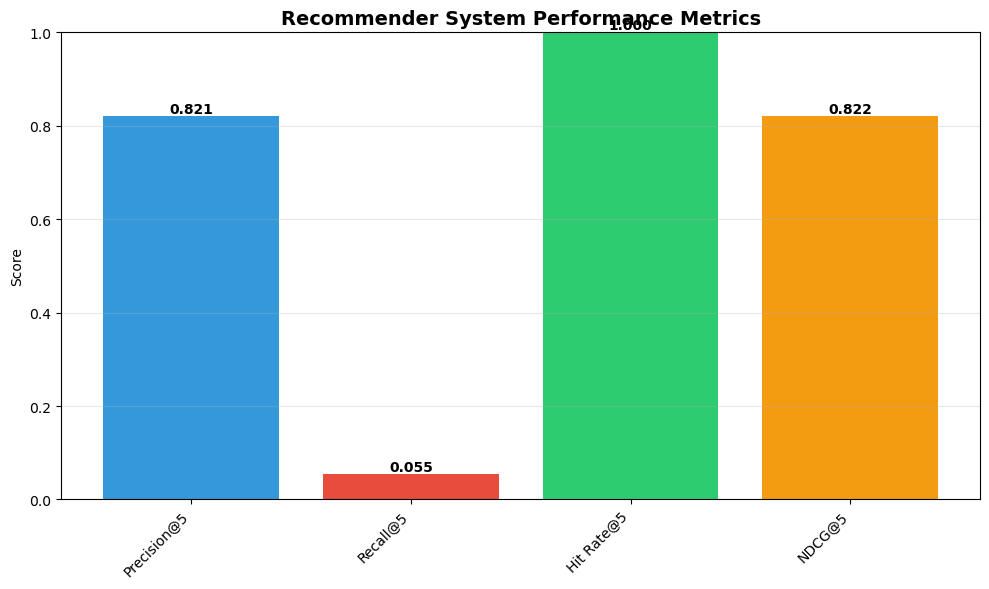


[3/5] Generating distribution plots...


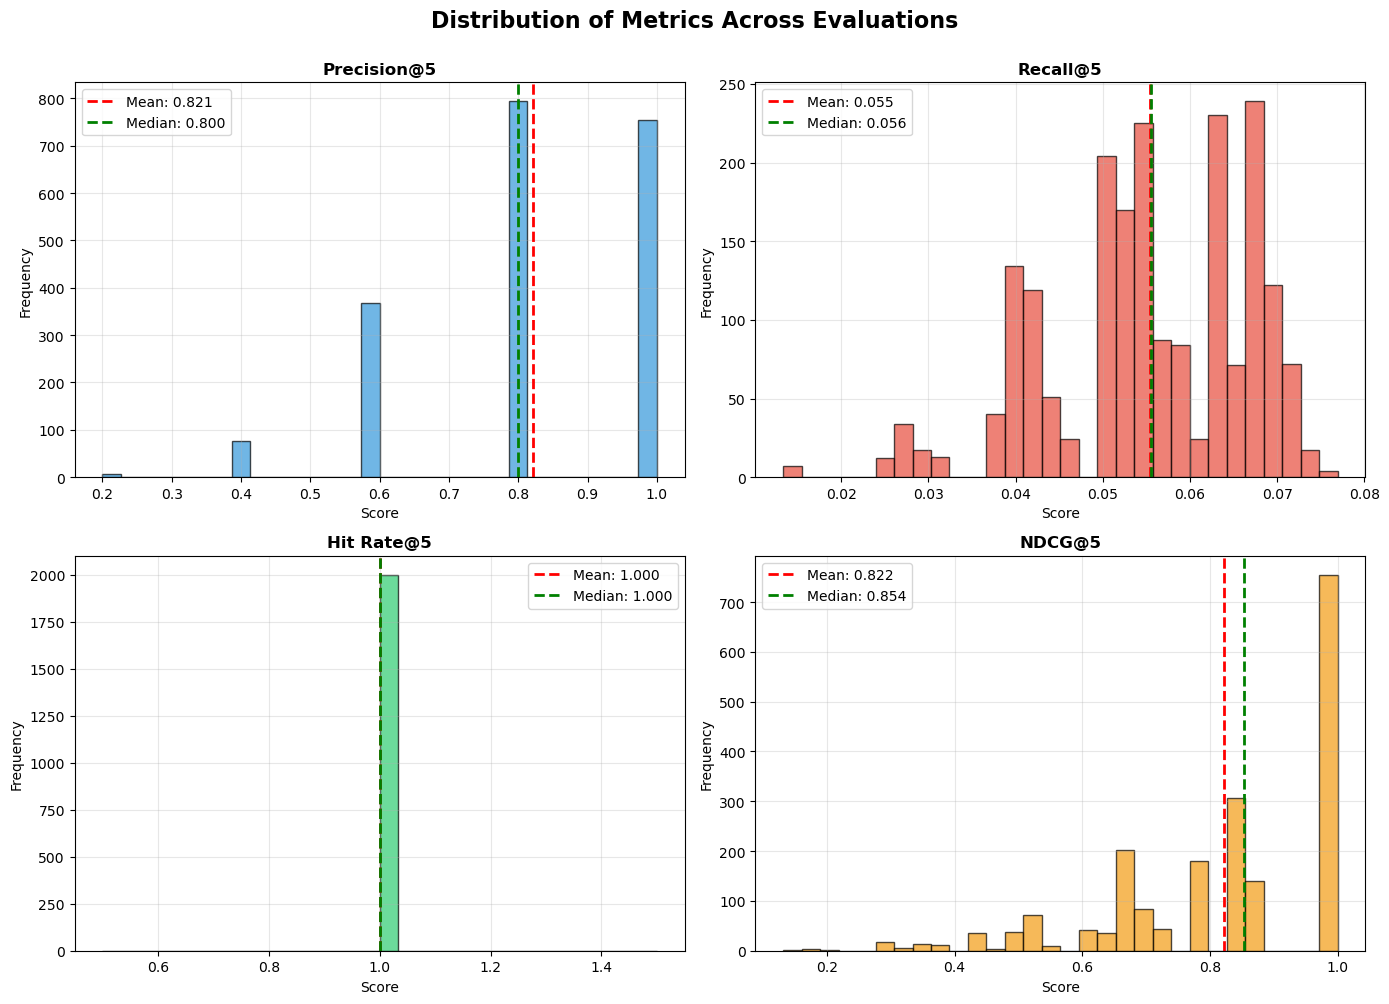


[4/5] Evaluating multiple K values...

Results by K:
 K  Precision   Recall  Hit Rate     NDCG
 1   0.827000 0.011158    0.8270 0.827000
 3   0.818167 0.033123    0.9945 0.819738
 5   0.821400 0.055428    1.0000 0.821547
10   0.818050 0.110371    1.0000 0.819012


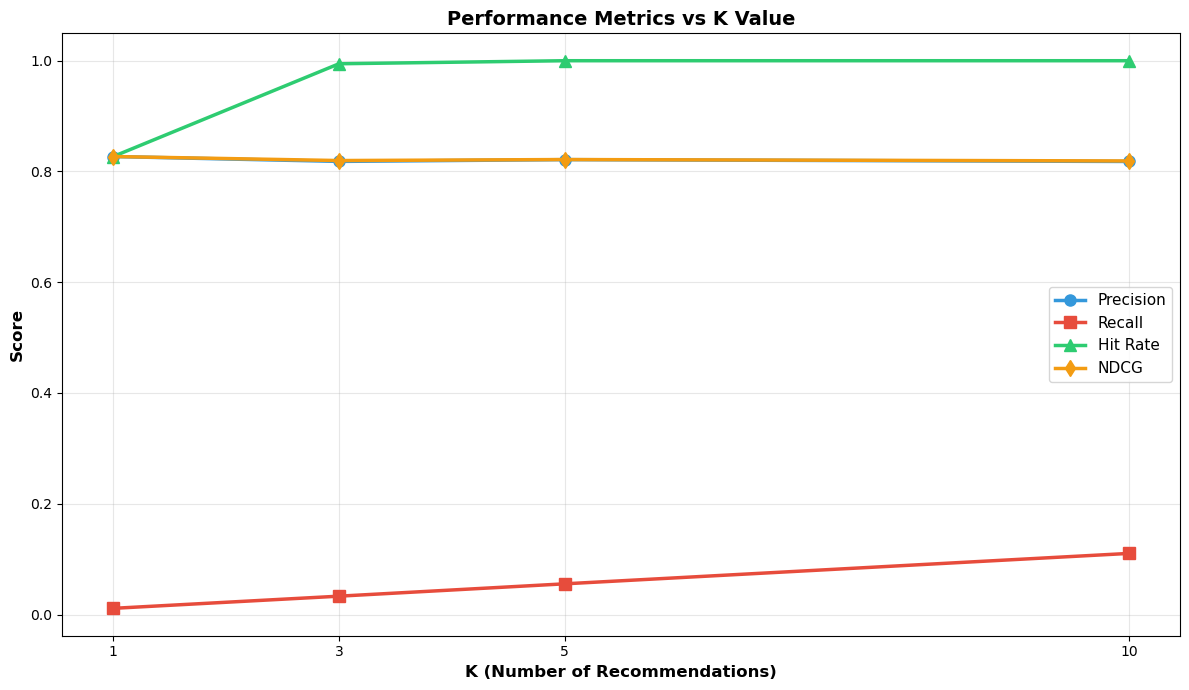


[5/5] Comparing across interaction types...


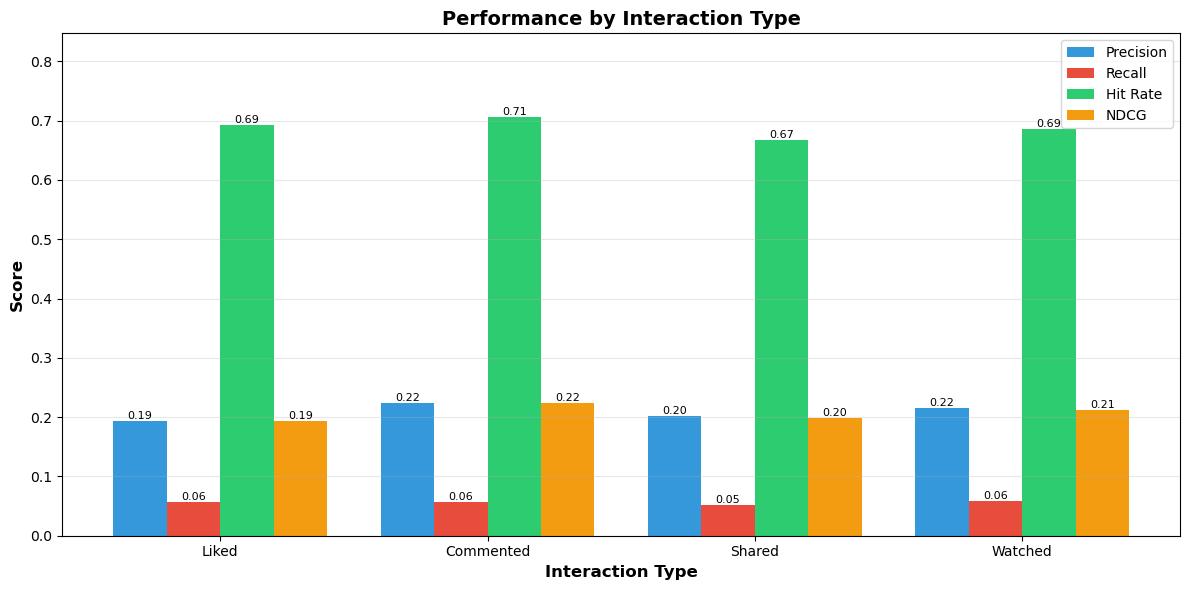


Generating correlation heatmap...


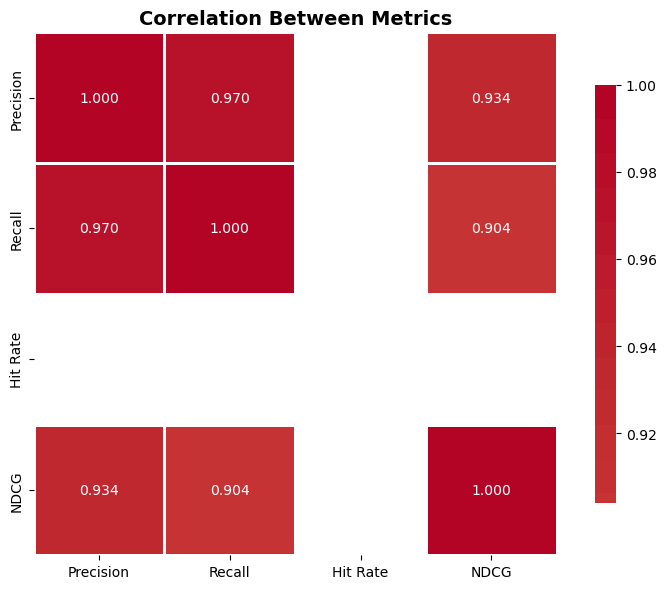


REPORT GENERATION COMPLETE


In [7]:
#Example usage
if __name__ == "__main__":
    # Load your data and models
    dataset = pd.read_csv('interaction_data.csv')
    dataset = dataset.drop_duplicates(subset='video_title', keep='first').reset_index(drop=True)
    dataset['content'] = (dataset['video_title'] + 
                         dataset['video_description'] + 
                         dataset['video_tags'])
    
    nn_model = joblib.load('nearest_neighbors_model.pkl')
    tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
    
    # Initialize evaluator
    evaluator = VideoRecommenderEvaluator(
        nn_model=nn_model,
        tfidf_vectorizer=tfidf_vectorizer,
        dataset=dataset,
        k=5
    )
    
    # Generate full report with all visualizations
    interaction_data = pd.read_csv('interaction_data.csv')
    evaluator.generate_full_report(interaction_data, sample_size=2000)